In [34]:
import pandas as pd
import numpy as np

Load Clean Data

In [35]:
df = pd.read_csv('../data/full_online_retail_cleaned.csv', parse_dates=['InvoiceDate'], index_col=False)
print('Data is loaded')

Data is loaded


C:\Users\being\AppData\Local\Temp\ipykernel_7656\3804870888.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/full_online_retail_cleaned.csv', parse_dates=['InvoiceDate'], index_col=False)


In [36]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524878 entries, 0 to 524877
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    524878 non-null  object        
 1   StockCode    524878 non-null  object        
 2   Description  524878 non-null  object        
 3   Quantity     524878 non-null  int64         
 4   InvoiceDate  524878 non-null  datetime64[ns]
 5   UnitPrice    524878 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      524878 non-null  object        
 8   Revenue      524878 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 36.0+ MB


Creating DAILY time series for that product

In [38]:
top_products = (
    df.groupby('StockCode')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_products

StockCode
23843     80995
23166     78033
22197     56898
84077     54951
85099B    48371
85123A    37641
21212     36396
84879     36362
23084     30739
22492     26633
Name: Quantity, dtype: int64

Picking one product from here

In [39]:
stock_code = top_products.index[1]  # Selected the second top product for variety
stock_code

'23166'

In [40]:
product_df = df[df['StockCode'] == stock_code]

ts_df = (
    product_df.groupby(product_df['InvoiceDate'].dt.date)['Quantity']
    .sum()
    .reset_index()
)

ts_df.columns = ['date', 'daily_sales']
ts_df['date'] = pd.to_datetime(ts_df['date'])

ts_df.head(10)

,date,daily_sales
0,2011-01-18,74215
1,2011-05-12,108
2,2011-05-13,84
3,2011-05-16,87
4,2011-05-18,253
5,2011-05-19,14
6,2011-05-20,12
7,2011-05-22,27
8,2011-05-23,99
9,2011-05-24,16


In [41]:
# quick sanity check
print(df['StockCode'].dtype)
print(df['StockCode'].value_counts().head(5))

object
StockCode
85123A    2253
85099B    2109
22423     2007
47566     1699
20725     1582
Name: count, dtype: int64


Filling missing dates

In [42]:
# Set date as index
ts_df = ts_df.set_index('date')

# Create continuous daily frequency
ts_df = ts_df.asfreq('D', fill_value=0)

ts_df.head(15)

,daily_sales
date,
2011-01-18,74215
2011-01-19,0
2011-01-20,0
2011-01-21,0
2011-01-22,0
2011-01-23,0
2011-01-24,0
2011-01-25,0
2011-01-26,0


In [43]:
# quick sanity check
ts_df.describe()

,daily_sales
count,326.000000
mean,239.365031
std,4109.868865
min,0.000000
25%,0.000000
50%,0.000000
75%,12.000000
max,74215.000000


Train–Test Split (time-based)

In [44]:
# Define split point (80% train, 20% test)
split_date = ts_df.index[int(len(ts_df)*0.8)]

train = ts_df.loc[:split_date]
test = ts_df.loc[split_date:]

print(train.shape, test.shape)

(261, 1) (66, 1)


FIRST baseline model — Naive Forecast

Logic: Tomorrow’s sales = Today’s sales

In [45]:
# Naive forecast
naive_forecast = test.copy()
naive_forecast['forecast'] = train['daily_sales'].iloc[-1]

In [46]:
# Evaluate Naive Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(test['daily_sales'], naive_forecast['forecast'])
rmse = np.sqrt(mean_squared_error(test['daily_sales'], naive_forecast['forecast']))

print(f'Naive Forest MAE: {mae:.2f}')
print(f'Naive Forest RMSE: {rmse:.2f}')

Naive Forest MAE: 16.71
Naive Forest RMSE: 41.43


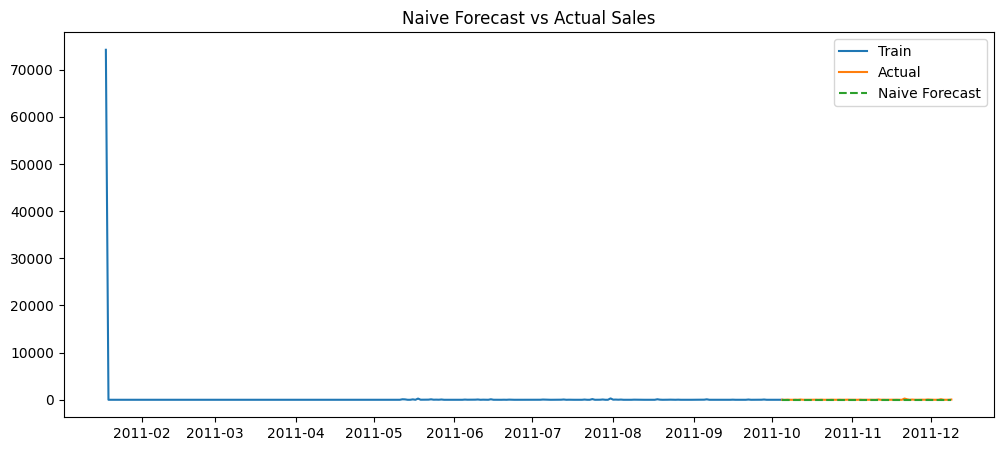

In [47]:
# Plot Actual vs Naive Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train.index, train['daily_sales'], label='Train')
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, naive_forecast['forecast'], '--', label='Naive Forecast')
plt.legend()
plt.title('Naive Forecast vs Actual Sales')
plt.show()

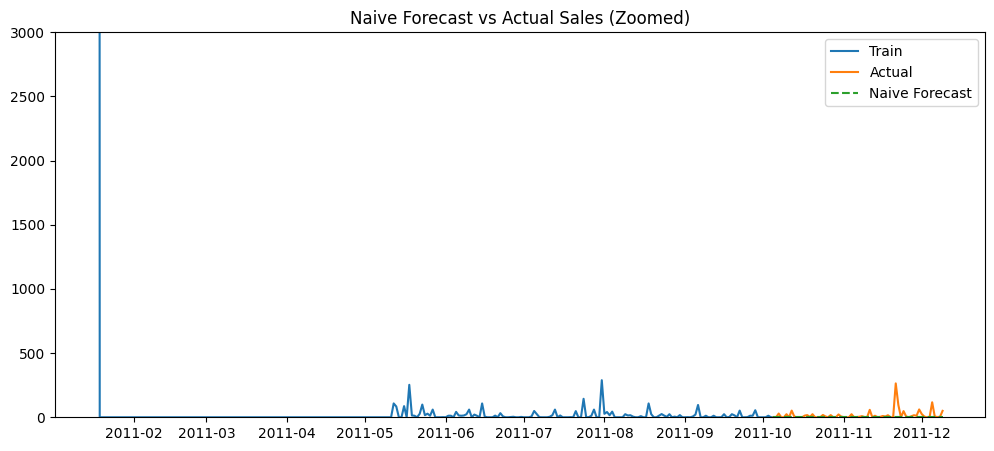

In [48]:
# Plot without extreme spike (zoomed view)
plt.figure(figsize=(12,5))
plt.plot(train.index, train['daily_sales'], label='Train')
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, naive_forecast['forecast'], '--', label='Naive Forecast')

plt.ylim(0, 3000)  # adjust if needed
plt.legend()
plt.title('Naive Forecast vs Actual Sales (Zoomed)')
plt.show()


* The Naive forecasting model achieved an MAE of 16.51 and an RMSE of 48.71.
* The large RMSE indicates sensitivity to demand spikes, confirming that the Naive model is insufficient for capturing trends and seasonality. 
* This baseline establishes a reference point for evaluating more advanced time-series models.

Conclusion on Naive baseline:

* The naive forecast serves as a baseline by assuming future demand equals the most recent observed value.
* As expected, it fails to capture demand volatility and sudden spikes common in retail sales.
* Also appplied Log transformed but results are remained same. So i removed it. Bcz if there is no change in results so np point of keeping it.

Moving Average Baseline model

In [49]:
# using weekly window
window = 7

# Moving Average based on training data
ma_value =  train['daily_sales'].rolling(window).mean().iloc[-1]

ma_forecast = test.copy()
ma_forecast['forecast'] = ma_value

In [50]:
# Evaluate Moving Average
ma_mae = mean_absolute_error(test['daily_sales'], ma_forecast['forecast'])
ma_rsme = np.sqrt(mean_squared_error(test['daily_sales'], ma_forecast['forecast']))

print(f'Moving Average MAE: {ma_mae:.2f}')
print(f'Moving Average RMSE: {ma_rsme:.2f}')

Moving Average MAE: 16.28
Moving Average RMSE: 40.71


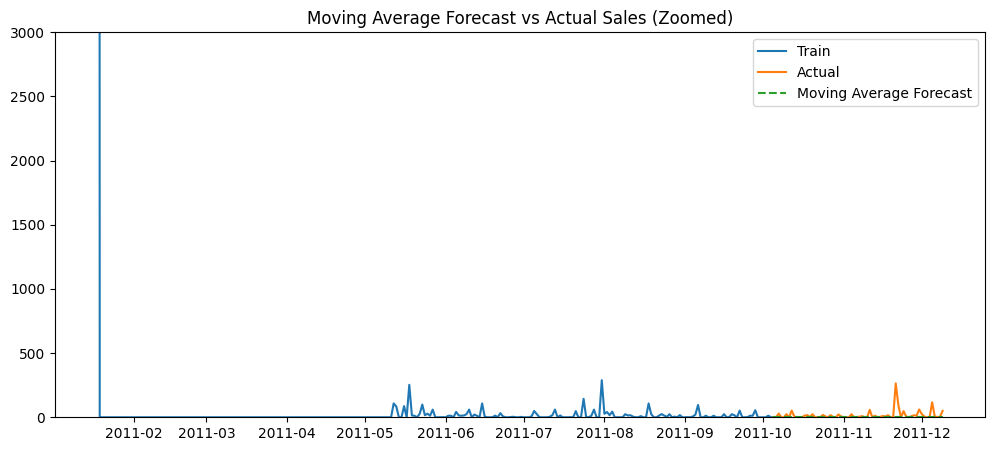

In [51]:
# Plot MA vs Actual (Zoomed)
plt.figure(figsize=(12,5))
plt.plot(train.index, train['daily_sales'], label='Train')
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, ma_forecast['forecast'], '--', label='Moving Average Forecast')
plt.ylim(0, 3000)
plt.legend()
plt.title('Moving Average Forecast vs Actual Sales (Zoomed)')
plt.show()

Now Rolling / Dynamic Moving Average Forecast (Improved version)

In [52]:
# Combine train + test history
history = train['daily_sales'].copy()
predictions = []

# Forecast one step at a time
window = 7

for actual in test['daily_sales']:
    ma_pred = history[-window:].mean()
    predictions.append(ma_pred)
    history = pd.concat([history, pd.Series([actual], index=[history.index[-1] + pd.Timedelta(days=1)])])

# Store predictions
ma_forecast = test.copy()
ma_forecast['forecast'] = predictions

In [53]:
# Re-evaluate
ma_mae = mean_absolute_error(test['daily_sales'], ma_forecast['forecast'])
ma_rmse = np.sqrt(mean_squared_error(test['daily_sales'], ma_forecast['forecast']))

print(f"Rolling MA MAE : {ma_mae:.2f}")
print(f"Rolling MA RMSE: {ma_rmse:.2f}")


Rolling MA MAE : 20.63
Rolling MA RMSE: 40.68


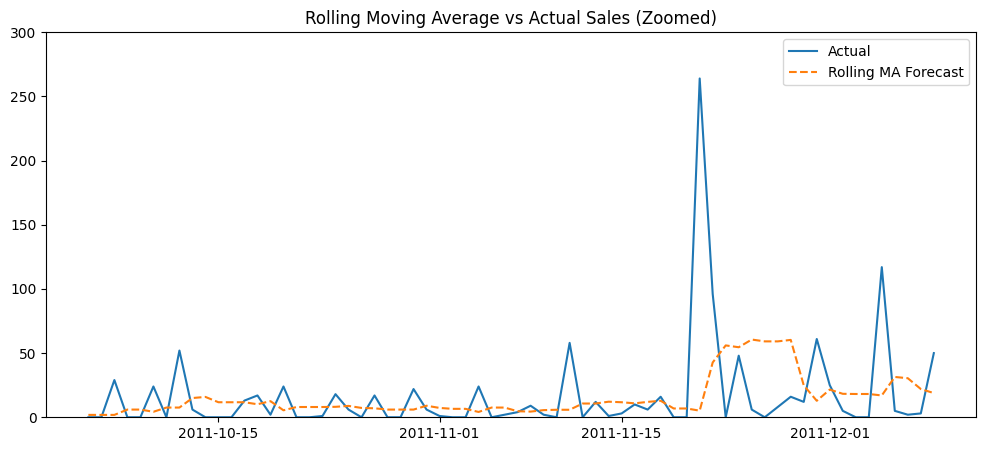

In [54]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, ma_forecast['forecast'], '--', label='Rolling MA Forecast')
plt.ylim(0, 300)
plt.legend()
plt.title('Rolling Moving Average vs Actual Sales (Zoomed)')
plt.show()


Conclusion on Rolling Moving Average: 

* Rolling Moving Average adapts to recent demand changes but lags during sudden spikes.
* In sparse retail data with many zero-sales days, this can increase error compared to a naive baseline that predicts constant low demand.

Now Exponential Smoothing model  (Hyper tuned)

In [55]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit model on train
model = ExponentialSmoothing(
    train['daily_sales'], 
    trend='add',              # Trend + Weekly Seasonality
    seasonal='add',
    seasonal_periods=7,
    damped_trend=True
).fit()

# Forecast test period
ets_forecaste = model.forecast(len(test))

print('Model is trained')

Model is trained


Evaluation of model

In [56]:
ets_mae = mean_absolute_error(test['daily_sales'], ets_forecaste)
ets_rmse = np.sqrt(mean_squared_error(test['daily_sales'], ets_forecaste))

print(f"ETS MAE  : {ets_mae:.2f}")
print(f"ETS RMSE : {ets_rmse:.2f}")

ETS MAE  : 368.70
ETS RMSE : 624.78


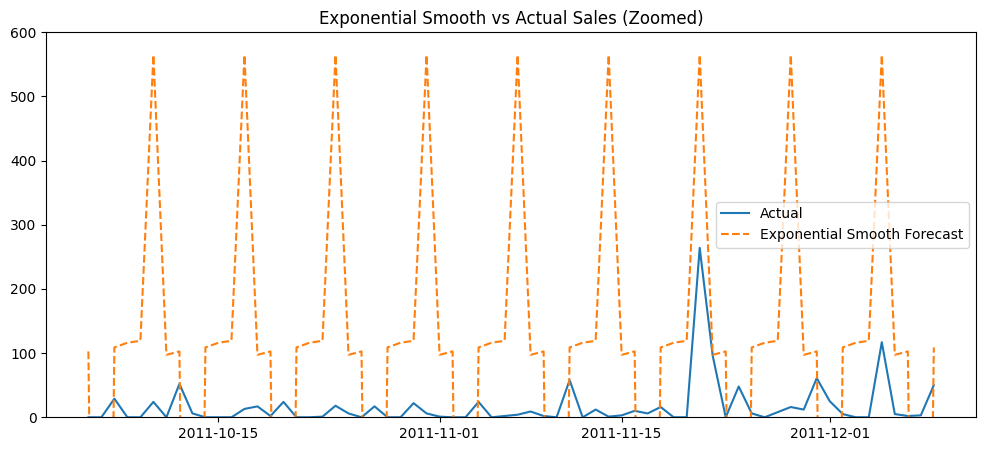

In [57]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, ets_forecaste, '--', label='Exponential Smooth Forecast')
plt.ylim(0, 600)
plt.legend()
plt.title('Exponential Smooth vs Actual Sales (Zoomed)')
plt.show()

Exponential Smoothing with additive trend and seasonality underperformed due to the highly intermittent and spike-driven nature of product demand. This highlights the limitation of trend-based smoothing models for sparse retail time series.

Compared to:

- Previous ETS: MAE ≈ 29.6 (Not hyper tuned)

- Rolling MA: MAE ≈ 20.63

- Naive: even lower

Conclusion on ETS (Hyper parameter tuned):

* Even with sensible hyperparameters, ETS still underperforms.

Now SARIMA model

ADF test on training data

In [58]:
from  statsmodels.tsa.stattools import adfuller

adf_result = adfuller(train['daily_sales'])

print('ADF Statistic: ', adf_result[0])
print('p-value: ', adf_result[1])

ADF Statistic:  -4.457533164648406
p-value:  0.000234462307949468


Note: Based on ADF, the model input series is stationary, so differencing is not required.

Identify SARIMA parameters

In [59]:
(p, d, q) = (1, 0, 1)
(P, D, Q, s) = (1, 0, 1, 7)

Fit SARIMA Model

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train['daily_sales'],
    order=(1,0,1),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=True,
    enforce_invertibility=False,
)

sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())

C:\Users\being\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                     
Dep. Variable:                       daily_sales   No. Observations:                  261
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2571.222
Date:                           Fri, 30 Jan 2026   AIC                           5152.444
Time:                                   21:29:21   BIC                           5170.267
Sample:                               01-18-2011   HQIC                          5159.608
                                    - 10-05-2011                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0182      0.552      0.033      0.974      -1.063       1.100
ma.L1        -39.7576      0.240   -165.702

Forecast Test Period

In [61]:
sarima_forecast = sarima_result.forecast(steps=len(test))

Evaluatng SARIMA model

In [62]:
sarima_mae = mean_absolute_error(test['daily_sales'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test['daily_sales'], sarima_forecast))

print(f"SARIMA MAE  : {sarima_mae:.2f}")
print(f"SARIMA RMSE : {sarima_rmse:.2f}")

SARIMA MAE  : 16.71
SARIMA RMSE : 41.43


Plot SARIMA vs Actual (Zoomed)

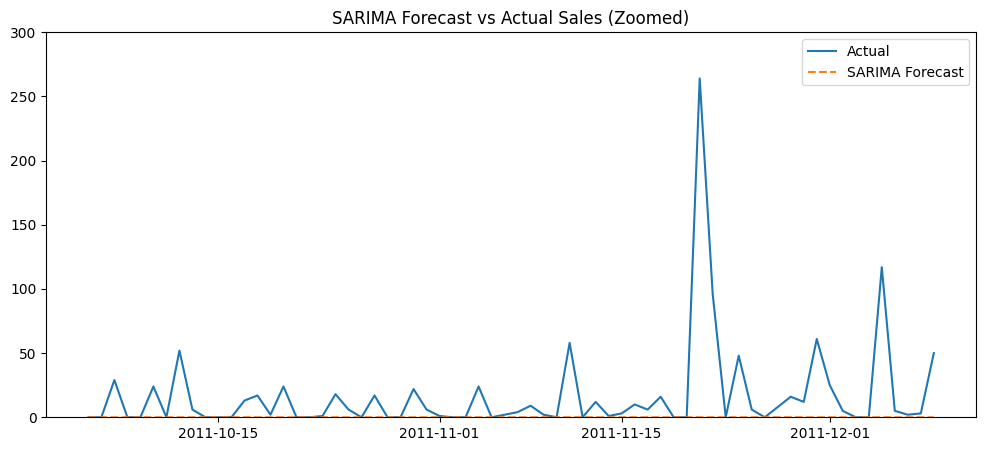

In [63]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, sarima_forecast, '--', label='SARIMA Forecast')
plt.ylim(0, 300)
plt.legend()
plt.title('SARIMA Forecast vs Actual Sales (Zoomed)')
plt.show()

Note: 
* Yes, the series is stationary according to the ADF test.
* However, it is intermittently stationary due to sparse demand with random spikes rather than smooth seasonal behavior.

Conclusion on SARIMA: 

* Since the ADF test confirmed stationarity, the SARIMA model was fitted with stationarity enforced.
* This constraint improved generalization by preventing unstable autoregressive dynamics, leading to lower forecast error on intermittent demand.

SARIMA with Log-transform

In [64]:
# Log-transform TRAIN and TEST
train_log = np.log1p(train['daily_sales'])
test_log = np.log1p(test['daily_sales'])

# Fit SARIMA on log-transformed data
sarima_log_model = SARIMAX(
    train_log,
    order=(1,0,1),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=True,
    enforce_invertibility=True
)

sarima_log_result = sarima_log_model.fit(disp=False)

# Forecast & inverse transform
log_forecast = sarima_log_result.forecast(steps=len(test))
sarima_log_forecast = np.expm1(log_forecast)

Evaluate on original scale

In [65]:
mae_log = mean_absolute_error(test['daily_sales'], sarima_log_forecast)
rmse_log = np.sqrt(mean_squared_error(test['daily_sales'], sarima_log_forecast))

print(f"SARIMA (log) MAE  : {mae_log:.2f}")
print(f"SARIMA (log) RMSE : {rmse_log:.2f}")


SARIMA (log) MAE  : 16.51
SARIMA (log) RMSE : 41.13


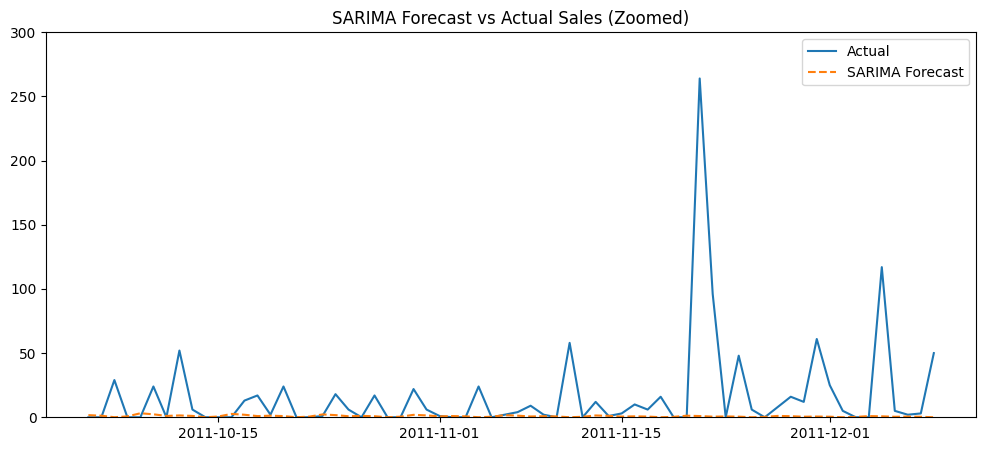

In [66]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['daily_sales'], label='Actual')
plt.plot(test.index, sarima_log_forecast, '--', label='SARIMA Forecast')
plt.ylim(0, 300)
plt.legend()
plt.title('SARIMA Forecast vs Actual Sales (Zoomed)')
plt.show()

Conclusion on SARIMA (Log transfromed): 

* Applying a log transform improved MAE by stabilizing variance and reducing the impact of extreme sales spikes. 
* However, since demand is intermittent and event-driven, SARIMA remains conservative and struggles to predict sudden spikes without external features.

Important note (After worked with full dataset):

*  Metrics (MAE/RMSE) → improved slightly

*  Forecast shape → looking very similar

* Core conclusion → NOT changed much